<a href="https://colab.research.google.com/github/CadeHarger/portfolio/blob/main/Personal_Projects/De_Conditioned_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Setup Dependencies
!pip install tensorflow-io

%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
import glob
import imageio
import tensorflow_probability as tfp
import time
import math
import cv2
import gc

from PIL import Image
from scipy.ndimage.filters import gaussian_filter
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [ ]:
#@title Setup MNIST Dataset
print(0 / 0)
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

trainData = preprocess_images(train_images)
testData = preprocess_images(test_images)

In [ ]:
#@title Mount Google Drive
import os
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
#@title Define Condition Functions
def getEdges(img, tolerance, blur, filter):
  condition = np.zeros(img.shape[:-1], dtype=np.float32)
  img = gaussian_filter(img, blur)
  for r in range(len(img) - 1):
    for c in range(len(img[0]) - 1):
      colorDistDown = math.sqrt(np.sum(np.square(img[r][c] - img[r + 1][c])))
      colorDistRight = math.sqrt(np.sum(np.square(img[r][c] - img[r][c + 1])))
      condition[r][c] = colorDistDown > tolerance or colorDistRight > tolerance
  if filter:
    for r in range(1, len(img) - 1):
      for c in range(1, len(img[0]) - 1):
        condition[r][c] = condition[r][c] and any((condition[r + 1][c], condition[r - 1][c], condition[r][c + 1], condition[r][c - 1]))
  return condition.flatten()

def getEdges2D(img, tolerance, blur, filter):
  condition = np.zeros(img.shape[:-1], dtype=np.float32)
  img = gaussian_filter(img, blur)
  for r in range(len(img) - 1):
    for c in range(len(img[0]) - 1):
      colorDistDown = math.sqrt(np.sum(np.square(img[r][c] - img[r + 1][c])))
      colorDistRight = math.sqrt(np.sum(np.square(img[r][c] - img[r][c + 1])))
      condition[r][c] = (colorDistDown > tolerance and colorDistRight > tolerance)
  if filter:
    for r in range(1, len(img) - 1):
      for c in range(1, len(img[0]) - 1):
        condition[r][c] = condition[r][c] and any((condition[r + 1][c], condition[r - 1][c], condition[r][c + 1], condition[r][c - 1]))
  return condition

In [ ]:
#@title Create Condition Set
rootdir = '/gdrive/MyDrive/AI Stuff/butterflies/valid/'
total = 0
folder = 0
directories = [x[1] for x in os.walk(rootdir)]
directories[0] = ['HEY DUDE'] + directories[0]
for subdir, dirs, files in os.walk(rootdir):
  print(folder, directories[0][folder], total)
  idx = 0
  for file in files:
    img = Image.fromarray(getEdges2D(np.asarray(Image.open(os.path.join(subdir, file))), 10, 1.122, True).astype(np.uint8) * 255)
    img.save(''.join(("/gdrive/MyDrive/AI Stuff/butterflies/conditions/", "valid_", directories[0][folder], "_", str(idx), ".jpg")))
    idx += 1
  total += idx
  folder += 1
print(total)

In [ ]:
#@title Partition Train Files
rootdir = '/gdrive/MyDrive/AI Stuff/butterflies/train/'
directories = [x[1] for x in os.walk(rootdir)]
directories[0] = ['HEY DUDE'] + directories[0]
total = 0
folder = 0
for subdir, dirs, files in os.walk(rootdir):
  print(folder, directories[0][folder], total)
  idx = 0
  for file in files:
    os.rename(os.path.join(subdir, file), ''.join(('/gdrive/MyDrive/AI Stuff/butterflies/dvae_train/', directories[0][folder], "_", str(idx), ".jpg")))
    idx += 1
  total += idx
  folder += 1
print(total)

In [ ]:
#@title Read Files into Dataset

def parallelShuffle(a, b, c):
  shuffler = np.random.permutation(len(a))
  return a[shuffler], b[shuffler], c[shuffler]

tic = time.perf_counter()
trainPath = '/gdrive/MyDrive/AI Stuff/butterflies/dvae_train/'
trainData = [cv2.imread(trainPath + filename) for filename in os.listdir(trainPath)]
trainData = np.array(trainData, dtype=np.int32)
toc = time.perf_counter()
print(f'Time: {toc - tic} seconds')

tic = time.perf_counter()
condPath = '/gdrive/MyDrive/AI Stuff/butterflies/conditions/'
trainConditions = [cv2.imread(condPath + filename, 0) for filename in os.listdir(trainPath)] # Use trainPath so files line up correctly in np arrays
trainConditions = np.array(trainConditions, dtype=np.int8)
toc = time.perf_counter()
print(f'Time: {toc - tic} seconds')
flatTrainConditions = np.reshape(trainConditions, (len(trainData), 224*224))
trainConditions = np.expand_dims(trainConditions, -1)

trainData = trainData.astype(np.float32) / 255.0
trainConditions = trainConditions.astype(np.float32) / 53.0
flatTrainConditions = flatTrainConditions.astype(np.float32) / 53.0

Time: 1096.6212060009998 seconds
Time: 1101.2684496250001 seconds


<Figure size 432x288 with 0 Axes>

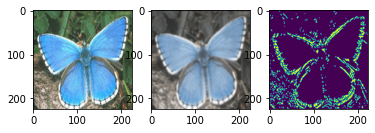

In [ ]:
#@title Test Condition on Single Example
# Images are 224 x 224

example = 19 #@param{type: "integer"}
blur =  1.2#@param{type: "number"}
tolerance = 10#@param{type: "number"}
filter = True#@param{type: "boolean"}
img = Image.open("/gdrive/MyDrive/AI Stuff/butterflies/dvae_train/adonis_5.jpg")
img = np.asarray(img)

plt.figure()
f, axarr = plt.subplots(1, 3)
axarr[0].imshow(img)
axarr[1].imshow(gaussian_filter(img, blur))
axarr[2].imshow(getEdges2D(img, tolerance, blur, filter))

In [ ]:
#@title Construct the Model
# U-net for the real images
# Will appending condition to inputs condense data and help encoder?
class DVAE(tf.keras.Model):
  def __init__(self, latentDimensions, encOpt, condOpt, decOpt, latentRatio=0.0001):
    super(DVAE, self).__init__()
    self.encOpt = encOpt
    self.condOpt = condOpt
    self.decOpt = decOpt
    self.lReconHist = []
    self.lDivHist = []
    self.lCondHist = []
    self.latentDimensions = latentDimensions
    self.latentRatio = latentRatio

    leaky = 0.1
    encInputs = tf.keras.layers.Input(shape=(224, 224, 3))
    first = tf.keras.layers.Conv2D(64, 3, strides=(2, 2), data_format='channels_last')(encInputs)
    x = tf.keras.layers.LeakyReLU(alpha=leaky)(first)
    x = tf.keras.layers.Conv2D(96, 3, strides=(2, 2), data_format='channels_last')(x)
    x = tf.keras.layers.LeakyReLU(alpha=leaky)(x)
    x = tf.keras.layers.Conv2D(128, 3, strides=(2, 2), data_format='channels_last')(x)
    x = tf.keras.layers.LeakyReLU(alpha=leaky)(x)
    x = tf.keras.layers.Conv2D(192, 3, strides=(2, 2), data_format='channels_last')(x)
    x = tf.keras.layers.LeakyReLU(alpha=leaky)(x)
    x = tf.keras.layers.Conv2D(256, 3, strides=(2, 2), data_format='channels_last')(x)
    x = tf.keras.layers.LeakyReLU(alpha=leaky)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(latentDimensions * 2)(x)
    self.encoder = tf.keras.Model(inputs = encInputs, outputs = x, name="Encoder")

    conditionInputs = tf.keras.layers.Input(shape=(latentDimensions,))
    x = tf.keras.layers.Dense(14 * 14 * 2, activation='relu')(conditionInputs)
    x = tf.keras.layers.Reshape(target_shape=(14, 14, 2))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(filters=96, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(x)
    self.conditioner = tf.keras.Model(inputs = conditionInputs, outputs = x, name="Conditioner")

    decInputs = tf.keras.layers.Input(shape=(latentDimensions + 50176,))
    x = tf.keras.layers.Dense(14 * 14 * 16, activation='relu')(decInputs)
    x = tf.keras.layers.Reshape(target_shape=(14, 14, 16))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=leaky)(x)
    x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=leaky)(x)
    x = tf.keras.layers.Conv2DTranspose(filters=96, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=leaky)(x)
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=leaky)(x)
    x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same', activation='sigmoid')(x)
    self.decoder = tf.keras.Model(inputs = decInputs, outputs = x, name="Decoder")

    self.paramCount = ((np.sum([np.prod(v.get_shape().as_list()) for v in self.encoder.trainable_variables]) + np.sum([np.prod(v.get_shape().as_list()) for v in self.decoder.trainable_variables])) / 1e5).astype(np.float32)
    #self.encoder.summary()
    #self.conditioner.summary()
    #self.decoder.summary()

  @tf.function
  def sample(self, c, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latentDimensions))
    return self.decode(eps, c, apply_sigmoid=True)

  def decode(self, z, c, apply_sigmoid=False):
    logits = self.decoder(tf.concat([z, c], 1))
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

  def distEncode(self, x):
    mu, sigma = self.encode(x)
    return tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape = mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def log_normal_pdf(self, sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

  def compute_loss(self, x, c, c_flat):
    mean, logvar = self.encode(x)
    z = self.reparameterize(mean, logvar)
    z_condition = self.conditioner(z)
    x_logit = model.decoder(tf.concat([z, c_flat], 1))
    logpx_z = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x), axis=[1, 2, 3])
    lCond = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=z_condition, labels=c), axis=[1])
    logpz = self.log_normal_pdf(z, 0., 0.)
    logqz_x = self.log_normal_pdf(z, mean, logvar)

    lRecon = -tf.reduce_mean(logpx_z)# / tf.constant([self.paramCount])
    lDiv = -tf.reduce_mean(logpz - logqz_x) / tf.constant(self.latentRatio)# / tf.constant([self.latentDimensions / self.latentRatio])

    self.lReconHist.append(lRecon)
    self.lDivHist.append(lDiv)
    self.lCondHist.append(tf.reduce_mean(lCond))
    return (lRecon + lDiv, tf.reduce_mean(lCond),)

  def computeGradients(self, x, c, c_flat):
    with tf.GradientTape() as encTape, tf.GradientTape() as condTape, tf.GradientTape() as decTape:
        (lVAE, lCond,) = self.compute_loss(x, c, c_flat)
        lEnc = lVAE# - lCond
    enc_gradients = encTape.gradient(lEnc, self.encoder.trainable_variables)
    cond_gradients = condTape.gradient(lCond, self.conditioner.trainable_variables)
    dec_gradients = decTape.gradient(lVAE, self.decoder.trainable_variables)
    return enc_gradients, cond_gradients, dec_gradients

  @tf.function
  def apply_gradients(self, enc_gradients, cond_gradients, dec_gradients):
      self.encOpt.apply_gradients(
          zip(enc_gradients, self.encoder.trainable_variables)
      )
      self.condOpt.apply_gradients(
          zip(cond_gradients, self.conditioner.trainable_variables)
      )
      self.decOpt.apply_gradients(
          zip(dec_gradients, self.decoder.trainable_variables)
      )

  def train(self, x, c, c_flat):
    enc_gradients, cond_gradients, dec_gradients = self.computeGradients(x, c, c_flat)
    self.apply_gradients(enc_gradients, cond_gradients, dec_gradients)

model = DVAE(700, tf.keras.optimizers.Adam(5e-5), tf.keras.optimizers.Adam(2e-4), tf.keras.optimizers.Adam(5e-5))

In [ ]:
#@title Train the Model

epochs = 14
batchSize = 20

for epoch in range(epochs):
  print(f"Epoch: {epoch + 1}")
  tic = time.perf_counter()
  for batch in range(int(len(trainData) / batchSize)):
    if batch % 34 == 0:
      print(batch)
    model.train(
        trainData[batch * batchSize: batch * batchSize + batchSize],
        trainConditions[batch * batchSize: batch * batchSize + batchSize],
        flatTrainConditions[batch * batchSize: batch * batchSize + batchSize]
    )
  print(f"Reconstruction Loss: {np.sum(model.lReconHist[-1])}")
  print(f"Divergence Loss: {np.sum(model.lDivHist[-1])}")
  print(f"Conditioner Loss: {np.sum(model.lCondHist[-1])}")
  print(f"Time: {time.perf_counter() - tic} seconds\n")
  gc.collect()
  shuffler = np.random.permutation(len(trainData))
  trainData = trainData[shuffler]
  gc.collect()
  trainConditions = trainConditions[shuffler]
  gc.collect()
  flatTrainConditions = flatTrainConditions[shuffler]
  gc.collect()

Epoch: 1
0
34
68
102
136
170
204
238
Reconstruction Loss: 60.03914260864258
Divergence Loss: 0.006995548028498888
Conditioner Loss: 155.2647705078125
Time: 254.07250449799903 seconds

Epoch: 2
0
34
68
102
136
170
204
238
Reconstruction Loss: 60.03843307495117
Divergence Loss: 0.0024423645809292793
Conditioner Loss: 155.26483154296875
Time: 222.60061587199925 seconds

Epoch: 3
0
34
68
102
136


In [ ]:
plt.plot(np.array(model.lReconHist))

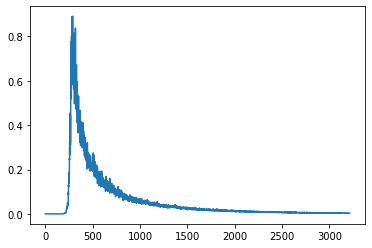

In [ ]:
plt.plot(np.array(model.lDivHist))

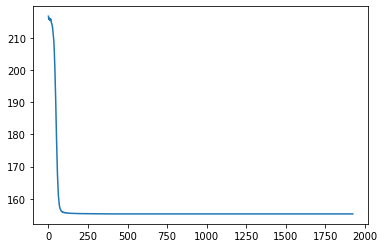

In [ ]:
plt.plot(np.array(model.lCondHist))

1.6017543e-12 0.38600066 2


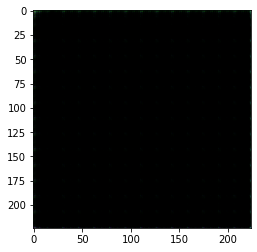

In [ ]:
#@title Test the Model
testCase = 1#@param{type:"integer"}
testCase += 1
conditionCase = 1#@param{type:"integer"}
conditionCase += 1
latentOne = 0 #@param {type:"slider", min:0, max:1, step:0.01}
latentTwo = 0 #@param {type:"slider", min:0, max:1, step:0.01}
mu, sigma = model.encode(trainData[testCase:testCase + 1])
mu2 = mu.numpy()
mu2[0][0] += sigma[0][0] * latentOne
mu2[0][1] += sigma[0][1] * latentTwo
x = model.decode(model.reparameterize(mu2, sigma), flatTrainConditions[conditionCase:conditionCase + 1])
print(np.min(x), np.max(x), testCase)
z = np.squeeze(x.numpy())
z -= np.min(z)
z /= np.max(z)
plt.imshow(z)

0.000988014 0.0


<Figure size 432x288 with 0 Axes>

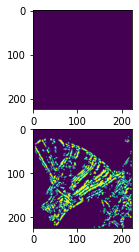

In [ ]:
#@title Compare Predicted Condition
testCase = 26#@param{type:"integer"}
mu, sigma = model.encode(trainData[testCase:testCase + 1])
z = model.reparameterize(mu, sigma)
z_condition = np.squeeze(model.conditioner(z).numpy())

print(np.max(z_condition), np.min(z_condition))
plt.figure()
f, axarr = plt.subplots(2,1)
axarr[0].imshow(z_condition)
axarr[1].imshow(getEdges2D(trainData[testCase] * 255, 10, 1.2, True))